# Generating Music with Genetic Algorithms

Genetic Algorithms are a subset of evolutionary computing; biologically inspired optimization with population-based trial and error search. Loosely speaking, a genetic algortihm creates a popultation of entities that can be modified, combined, and evaluated for fitness wrt an optimization goal. The simplest optimization step works as follows; create a population, check which elements are most fit (best suited to the optimization problem), keep only the most fit, modify and recombine elements to create new element for the next generation, repeat.

### The components:
- genetic representation
- population
- genetic operations: mutation and recombination
- fitness
- selection
- sources of randomness

Genetic algorithms are inspired by natural selection. Here is a simple simulation of natural selection (choose the lab): https://phet.colorado.edu/sims/html/natural-selection/latest/natural-selection_en.html

### Introduction Exercise:
- note all the ways you can change the genetic operations
- note all the ways you can change the fitness function

### The components in the following code example:
- genetic representation: each element is a chord progression with at least 1 chord
- population: the population consists of 60 
- genetic operations: 
1) point mutation of progression; randomly choose a chord and invert it or add an accidental
2) recombination of progression; split or join chord sequences
- fitness: penalize and encourage several pitch relationshipts between adjacent chords
- selection: pick the best 50 progressions and add 10 new ones (with a single chord)
- sources of randomness: in the mutation and recombination as well as adding 10 random new ones.

## Exercises

### Starting from the chords

1. understand the code below
2. play around with the optimization loop while changing the modify function: do you see things that should be fixed in the genetic representation? what are they and can you change them?
3. write a two step selection; first mutate/modify elements and select the fittest (with some randomness), then recombine them and select the fittest from offspring and parent elements (with some randomness)

### Adding some melody

pure chord progressions are boring, write a genetic algorithm for melody generation: 

1. get an overall idea of what your algorithm looks like, maybe draw a flow chart or take some notes.
2. how do you represent a melody? write a melody element class.
3. write modifiers for melodies
4. the environment is given by one progression from the progression generation code; pick one and write a fitness function that returns a score for how well the melody fits the progression. This is the most complex task and probably requires some thinking, creativity, and experimentation. take your time!
5. write an optimization scheme for the melody generation and add the fittest melody to a partitura part (hint: there is a addnote function in the helpers.py file)

In [41]:
import partitura as pt
import numpy as np
from scipy.spatial.distance import pdist
from itertools import product
import random, string

In [42]:
def cycle_distance(u,v):
    """
    pitch class distance between two values u and v
    """
    a = np.sqrt(((u%12-v%12)%12)**2)
    b = np.sqrt(((v%12-u%12)%12)**2)
    return np.min([a, b])

def chordDistance(c1, c2):
    """
    compute the minimal distance between to chords
    when every note of the second chord
    can be transposed by up to -1 / +1 octaves 
    
    """
    l = min(c1.shape[0],c2.shape[0])
    c1 = c1[:l]
    c2 = c2[:l]
    local_adds = dict()
    adds = []
    for comb in product(np.arange(-1,1), repeat =  l):
        c=np.array(comb)
        new_c2 = c2 + 12* c
        # pd = pdist(new_c2.reshape(-1,1), cycle_distance)
        total = np.sum(np.abs(new_c2-c1))
        adds.append(total)
        local_adds[total] = c
    
    best_total = np.min(adds)
    best_adds = local_adds[best_total]
    # print("best adds", best_adds, "best_total", best_total)
    
    return  best_adds, best_total

def randomword(length):
    """
    a random character generator
    """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

In [43]:
class Progression:
    """
    the Progression class representing a sequence of chords
    """
    def __init__(self, chords = list()):
        self.chords = chords
        self.id = randomword(10)
    
    def add_chord(c):
        self.chords.append(c)

    def join(self, another):
        self.chords += another.chords
    
    def split(self):
        if len(self.chords) > 1:
            split_idx = np.random.randint(1,len(self.chords))
            tail = Progression(self.chords[split_idx:])
            self.chords = self.chords[:split_idx]
            return tail
        else:
            return self

In [44]:
class Chord:
    """
    the Chord class representing a chord made of 3-4 notes of a scale.
    For diatonic scales the intervals between notes are thirds.
    """
    def __init__(self, 
                 offset = np.random.randint(48,60), 
                 scale = np.array([0,2,4,5,7,9,11])):
        
        self.offset = offset
        self.scale = scale
        self.root_id = np.random.randint(self.scale.shape[0])
        self.root = self.offset + self.scale[self.root_id]
        self.how_many = np.random.randint(3,5)
        if self.how_many == 3:
            self.jumps = [2,2,3]
        elif self.how_many == 4:
            self.jumps = [2,2,2,1]
        self.jumps_cs = np.cumsum([0]+ self.jumps) 
        self.inversion = 0
        self.inversion_jumps = None
        self.inversion_jumps_cs = None
        self.all_ids = None
        self.pitches = None
        self.pitch_classes = None
        self.pitch_classes_relative = None
        self.repitch = [0,0]
        self.compute_pitch()
        self.name = self.get_name()
        
    def get_name(self):
        root_names = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
        root_name = root_names[self.root%12]
        first_jump =  cycle_distance(self.scale[(self.root_id+self.jumps[0])%self.scale.shape[0]],
                                      self.scale[self.root_id])
        if first_jump == 3:
            mod = "m"
        elif first_jump == 4:
            mod = "M"
        else:
            mod = "?"
        
        if self.how_many == 3:
            typ = ""
        elif self.how_many == 4:
            typ = "7"
        elif self.how_many == 5:
            typ = "79"
        else:
            typ = "jazz?"
            
        repitch_names = {1:"#", -1:"b"}
        if self.repitch != [0,0]:
            chromatic = "_" + str(self.repitch[0]) +repitch_names[self.repitch[1]]
        else:
            chromatic = ""
        name = root_name + mod + typ + "_" + str(self.inversion) + chromatic
        return name
        
    def compute_pitch(self):
        self.inversion_jumps = self.jumps[self.inversion:]+self.jumps[:self.inversion]
        self.inversion_jumps_cs = np.cumsum([0]+ self.inversion_jumps) 
        self.all_ids = np.array([(self.root_id+self.jumps_cs[self.inversion])%self.scale.shape[0]
                                 +self.inversion_jumps_cs[n] for n in range(self.how_many)])
        self.pitches = self.offset + np.concatenate((self.scale, self.scale+12))[self.all_ids]
        self.pitches[self.repitch[0]] += self.repitch[1]
        self.pitch_classes = self.pitches%12
        self.pitch_classes_relative = (self.pitches-self.offset)%12
        self.name = self.get_name()
        
    
    def invert(self, n):
        n %= self.how_many
        self.inversion = n
        self.compute_pitch()
        
    def add_repitch(self, idx, mod):
        idx %= self.how_many
        self.repitch = [idx, mod]
        self.compute_pitch()
    

In [45]:
"""
MODIFIERS
"""
def modify(population):
    # split some elements
    subpop0 = np.random.choice(population, 4)
    for element in subpop0:
        population.append(element.split())
    # join some elements
    subpop1 = np.random.choice(population, 10)
    subpop2 = np.random.choice(population, 10)
    for element0, element1 in zip(subpop1, subpop2):
        element0.join(element1)
    
    # add an accidental
    subpop3 = np.random.choice(population, 10)
    for element in subpop3:
        cidx = np.random.randint(len(element.chords))
        nidx = np.random.randint(4)
        mod = np.random.choice([-1,1])
        element.chords[cidx].add_repitch(0,0)
    # invert a chord
    subpop4 = np.random.choice(population, 10)
    for element in subpop4:
        cidx = np.random.randint(len(element.chords))
        nidx = np.random.randint(4)
        element.chords[cidx].invert(nidx)
    return population

In [46]:
"""
SELECT
"""
def fitness(progression):
    # the lower the fitness score the better
    fit = 0
    for c0,c1 in zip(progression.chords[:-1], progression.chords[:-1]):
        _, dist = chordDistance(c0.pitches, c1.pitches)
        # penalize big leaps between pitches of adjacent chords
        fit += dist 
        # penalize big leaps between scale tonic of adjacent chords
        fit += abs(c0.offset - c1.offset)
        # penalize small leaps between root of adjacent chords
        fit += abs(5.0 - cycle_distance(c0.root,c1.root))
    
    # encourage chord sequences > 1 chords
    fit += len(progression.chords) * -50
    # add a small random number for hashing
    fit += np.random.rand(1)[0]
    
    if len(progression.chords) > 8:
        # penalize long sequences
        fit += (len(progression.chords)-8)*200
    return fit 

def select(population, number):
    pop = {ele.id:ele for ele in population}
    fitness_dict = {fitness(ele):ele.id for ele in population}
    sorted_fitness = list(fitness_dict.keys())
    sorted_fitness.sort()
    # print(sorted_fitness)
    # print([(len(pop[fitness_dict[k]].chords), k) for k in sorted_fitness[:50]])
    new_pop = [pop[fitness_dict[k]] for k in sorted_fitness[:50] if len(pop[fitness_dict[k]].chords)<30]
    return new_pop

In [47]:
"""
LOOP
"""
population = [Progression([Chord()]) for po in range(60)]
for epoch in range(20): 
    print("................", epoch)
    population = modify(population)
    population = select(population, 50)    
    population += [Progression([Chord()]) for po in range(10)]
    
    # print the length of chord progressions
    longer_prog = [len(f.chords) for f in population if len(f.chords) > 1]
    longer_prog.sort()
    print(longer_prog) 

................ 0
[2, 2, 2, 2, 2, 2, 2, 2, 3]
................ 1
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4]
................ 2
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 6]
................ 3
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 6]
................ 4
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 6, 7]
................ 5
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 7, 7, 8]
................ 6
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 7, 7, 7, 7, 8, 9, 9, 10]
................ 7
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 9, 9, 9, 10, 10]
................ 8
[2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6

In [48]:
choice = 0
for c in population[choice].chords: print(c.name)

D#M7_0
G#M_0
D#M7_0
Cm_0
D#M_2
G#M_0
C#M_1
Gm7_3


In [49]:
from synthesize_score import synthesize_data
import IPython.display as ipd
from helpers import partFromProgression

In [50]:
SAMPLE_RATE = 44100

part = partFromProgression(population[choice])
audio = synthesize_data(part, # input your values here!
                        samplerate=SAMPLE_RATE)

audio /= 4 # a bit quieter
ipd.display(ipd.Audio(data=audio, rate=SAMPLE_RATE, normalize=False))

In [51]:
import matplotlib.pyplot as plt

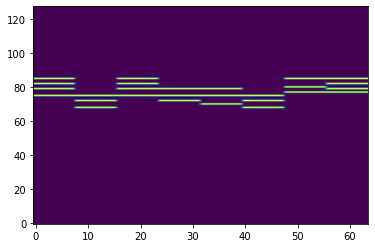

In [54]:
%matplotlib inline
piano_roll = pt.utils.music.compute_pianoroll(part)
plt.imshow(piano_roll.todense(), aspect = "auto", origin="lower")